In [1]:
%load_ext autoreload

%autoreload 2

# Imports
import os
import torch
import numpy as np

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

import trainutils

# Create Training and Test Sets

## Load training data

In [2]:
# Construct X = folder names, y = the label

feature_folder = 'sync_measure_data/features_v1'

X_paths = [] # paths to feature files
y = []       # designated label

for file_name in os.listdir(feature_folder):

    X_paths.append(feature_folder + '/' + file_name)

    # extracting class label from the file name
    #
    label = int(file_name.split('.')[0].split("_")[-1])

    y.append(label)

In [3]:
# Preview Data distribution
from collections import Counter
Counter(y)

Counter({1: 48, 2: 46, 4: 48, 5: 49, 8: 50, 9: 50, 0: 43, 3: 50, 6: 45, 7: 48})

In [4]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))
#print(test_X_paths)

Training Set: (381,381)
Test Set: (96,96)


# Create Pytorch Dataset

In [5]:
# Set seeds for reproducibility
np.random.seed(4139)
torch.manual_seed(4139)

In [6]:
# Create Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y

    # Returns length
    def __len__(self):
        return len(self.X)

    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        with np.load(self.X[idx]) as data:
            X_feat = data['features']
        
        # Convert X to tensor
        X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx]

In [7]:
# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys)
print(len(training_dataset))

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys)
print(len(testing_dataset))

# number of features per frame
num_features = training_dataset[0][0].shape[1]

print('num_features:', num_features)

381
96
num_features: 33


In [8]:
# Grab a row to see contents
sample_X, sample_y = training_dataset[1]
sample_X.shape, sample_y

(torch.Size([101, 33]), 0)

# Define Data Loader  

Data Loader for extracting batches from the Pytorch Dataset during model training

In [9]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [107]:
# Specify batch size
batch_size = 10

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

In [108]:
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([10, 101, 33]) torch.Size([10])
torch.Size([10, 101, 33]) torch.Size([10])


# Model Definition 

In [109]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]

        # Define Model Structure
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)

    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame)
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))

        output = self.fc1(output)
        return output
        

In [110]:
# RNN Model Parameters
model_params = {
    "num_classes": 10,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 200,
}
model = SyncRNN(model_params)

In [111]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.zeros(1, 101, num_features)
    y = model(x)
    print(y.shape) # should be [1,10]


torch.Size([1, 1, 10])


In [112]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Print Model Params
model = model.to(device)
model

cuda:0


SyncRNN(
  (rnn): LSTM(33, 200)
  (fc1): Linear(in_features=200, out_features=10, bias=True)
)

# Model Training  

Define loss function and optimizer to train the model

In [113]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(reduction="mean")

In [114]:
# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [115]:
# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor= 0.5, patience = 5, verbose = 1, min_lr = 1e-7)
os.makedirs("./models", exist_ok=True)

In [117]:
# Define Training Parameters - tweak this
train_params = {
    "num_epochs": 20,
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": "./models/weights_ebf_v1.pt",
}

In [118]:
trained_model, loss_hist, metric_hist = trainutils.train_model(model, train_params)

Epoch 0/19, current_lr=0.001



Saved best model weights
Train Loss: 0.235616, Dev Loss: 0.239832, Accuracy: 12.50
----------
Epoch 1/19, current_lr=0.001



Saved best model weights
Train Loss: 0.233110, Dev Loss: 0.238879, Accuracy: 10.42
----------
Epoch 2/19, current_lr=0.001



Saved best model weights
Train Loss: 0.232472, Dev Loss: 0.237842, Accuracy: 11.46
----------
Epoch 3/19, current_lr=0.001



Saved best model weights
Train Loss: 0.229964, Dev Loss: 0.237645, Accuracy: 9.38
----------
Epoch 4/19, current_lr=0.001



Train Loss: 0.228331, Dev Loss: 0.238778, Accuracy: 11.46
----------
Epoch 5/19, current_lr=0.001



Train Loss: 0.226852, Dev Loss: 0.239274, Accuracy: 7.29
----------
Epoch 6/19, current_lr=0.001



Train Loss: 0.225601, Dev Loss: 0.238519, Accuracy: 11.46
----------
Epoch 7/19, current_lr=0.001



Train Loss: 0.223083, Dev Loss: 0.238151, Accuracy: 11.46
----------
Epoch 8/19, current_lr=0.001



Train Loss: 0.218251, Dev Loss: 0.239061, Accuracy: 12.50
----------
Epoch 9/19, current_lr=0.001



Epoch    10: reducing learning rate of group 0 to 5.0000e-04.
Loading best model weights
Train Loss: 0.220694, Dev Loss: 0.242525, Accuracy: 9.38
----------
Epoch 10/19, current_lr=0.0005



Train Loss: 0.228362, Dev Loss: 0.238010, Accuracy: 10.42
----------
Epoch 11/19, current_lr=0.0005



Train Loss: 0.228295, Dev Loss: 0.238382, Accuracy: 12.50
----------
Epoch 12/19, current_lr=0.0005



Saved best model weights
Train Loss: 0.226606, Dev Loss: 0.236868, Accuracy: 14.58
----------
Epoch 13/19, current_lr=0.0005



Train Loss: 0.226735, Dev Loss: 0.239021, Accuracy: 11.46
----------
Epoch 14/19, current_lr=0.0005



Train Loss: 0.225281, Dev Loss: 0.238302, Accuracy: 13.54
----------
Epoch 15/19, current_lr=0.0005



Train Loss: 0.222753, Dev Loss: 0.238064, Accuracy: 11.46
----------
Epoch 16/19, current_lr=0.0005



Train Loss: 0.224520, Dev Loss: 0.239833, Accuracy: 12.50
----------
Epoch 17/19, current_lr=0.0005



Train Loss: 0.222519, Dev Loss: 0.240845, Accuracy: 6.25
----------
Epoch 18/19, current_lr=0.0005



Epoch    19: reducing learning rate of group 0 to 2.5000e-04.
Loading best model weights
Train Loss: 0.223330, Dev Loss: 0.239897, Accuracy: 10.42
----------
Epoch 19/19, current_lr=0.00025



Train Loss: 0.225798, Dev Loss: 0.238658, Accuracy: 8.33
----------


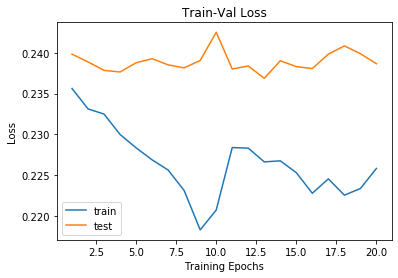

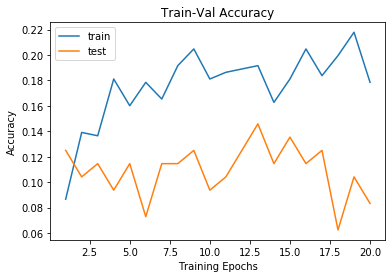

In [119]:
trainutils.plot_loss(loss_hist, metric_hist)